### 生成器

#### GAN 生成器网络

In [1]:
import keras
from keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# 将输入转换为大小为 16x16 的 128 通道的特征图
x = layers.Dense(128 * 16 * 16)(generator_input)
x = layers.LeakyReLU()(x)
x = layers.Reshape((16, 16, 128))(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 上采样为 32x32
x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(256, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

# 生成一个大小为 32x32 的单通道特征图（即 CIFAR10 图像的形状）
x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32768)             0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 32, 256)       1048832   
__________

### 判别器

#### GAN 判别器网络

In [7]:
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(128, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(128, 4, strides=2)(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

# 一个 dropout 层：这是很重要的技巧
x = layers.Dropout(0.4)(x)

# 分类层
x = layers.Dense(1, activation='sigmoid')(x)

# 将判别器模型实例化，它将形状为(32,32,3)的输入转换为一个二进制分类决策（真/假）
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

# 在优化器中使用梯度裁剪（限制梯度值的范围）
# 为了稳定训练过程，使用学习率衰减
discriminator_optimizer = keras.optimizers.RMSprop(
    lr=0.0008,
    clipvalue=1.0,
    decay=1e-8)

discriminator.compile(optimizer=discriminator_optimizer, 
                       loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_25 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_26 (LeakyReLU)   (None, 6, 6, 128)         0         
__________

### 对抗网络

#### 对抗网络

In [8]:
# 将判别器权重设置为不可训练（仅应用于 gan 模型）
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

#### 实现 GAN 的训练

In [12]:
import os
from keras.preprocessing import image

# 加载 CIFAR10 数据
(x_train, y_train), (_, _) = keras.datasets.cifar10.load_data()

# 选择青蛙图像（类别编号为 6）
x_train = x_train[y_train.flatten() == 6]

# 数据标准化
x_train = x_train.reshape(
    (x_train.shape[0],) + 
    (height, width, channels)).astype('float32') / 255.

iterations = 10000
batch_size = 20
save_dir = 'images/gan'   # 指定保存生成图像的目录

start = 0
for step in range(iterations):
    # 在潜在空间中采样随机点
    random_latent_vectors = np.random.normal(size=(batch_size,
                                                   latent_dim))
    # 将这些点解码为虚假图像
    generated_images = generator.predict(random_latent_vectors)
    
    # 将这些虚假图像与真实图像合在一起
    stop = start + batch_size
    real_image = x_train[start: stop]
    combined_images = np.concatenate([generated_images, real_image])
    
    # 合并标签，区分真是和虚假的图像
    labels = np.concatenate([np.ones((batch_size, 1)),
                             np.zeros((batch_size, 1))])
    # 向标签中添加随机噪声，这是一个很重要的技巧
    labels += 0.05 * np.random.random(labels.shape)
    
    # 训练判别器
    d_loss = discriminator.train_on_batch(combined_images, labels)
    
    # 在潜在空间中采样随机点
    random_latent_vectors = np.random.normal(size=(batch_size,
                                                   latent_dim))
    
    # 合并标签，全都是“真实图像”（这是在撒谎）
    misleading_targets = np.zeros((batch_size, 1))
    
    # 通过 gan 模型来训练生成器（此时冻结判别器权重）
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > len(x_train) - batch_size:
        start = 0
        
    # 每 100 步保存并绘图
    if step % 100 == 0:
        gan.save_weights('gan.h5')    # 保存模型权重
        
        # 将指标打印出来
        print('discriminator loss:', d_loss)
        print('adversarial loss:', a_loss)
        
        # 保存一张生成图像
        img = image.array_to_img(generated_images[0] * 255., scale=False)
        img.save(os.path.join(save_dir,
                              'generated_frog' + str(step) + '.png'))
        
        # 保存一张真实图像，用于对比
        img = image.array_to_img(real_image[0] * 255., scale=False)
        img.save(os.path.join(save_dir,
                              'real_frog' + str(step) + '.png'))

discriminator loss: 3.5984216
adversarial loss: 15.783483
discriminator loss: 1.1564958
adversarial loss: 0.98321533
discriminator loss: 0.70800436
adversarial loss: 0.7919347
discriminator loss: 0.6555446
adversarial loss: 3.1433706
discriminator loss: 0.6910502
adversarial loss: 0.7656783
discriminator loss: 0.6951298
adversarial loss: 0.73912215
discriminator loss: 0.69408536
adversarial loss: 0.7470359
discriminator loss: 0.7141268
adversarial loss: 0.82636386
discriminator loss: 0.6998371
adversarial loss: 0.75417185
discriminator loss: 0.6937798
adversarial loss: 0.76550967
discriminator loss: 0.6959633
adversarial loss: 0.7521432
discriminator loss: 0.70314753
adversarial loss: 0.72929853
discriminator loss: 0.68970966
adversarial loss: 0.74737585
discriminator loss: 0.68523866
adversarial loss: 0.7979475
discriminator loss: 0.7050343
adversarial loss: 0.86313516
discriminator loss: 0.70159185
adversarial loss: 0.76242435
discriminator loss: 0.6729363
adversarial loss: 0.9365171

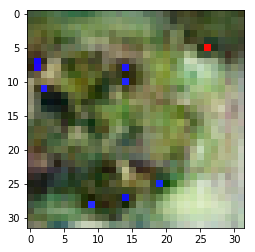

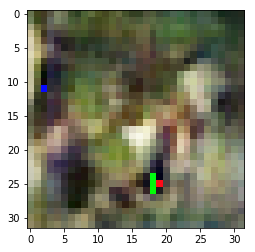

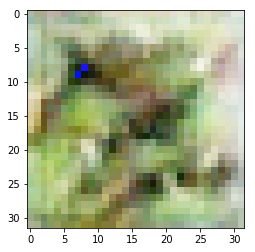

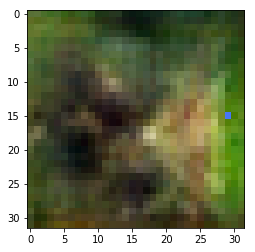

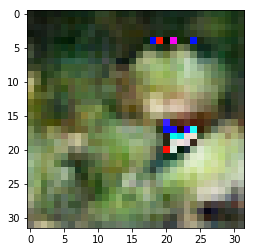

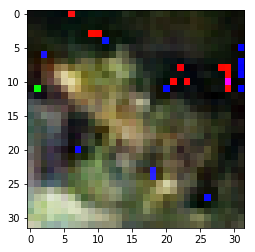

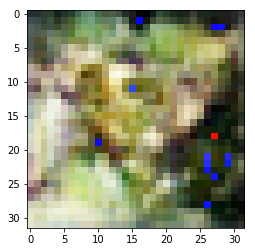

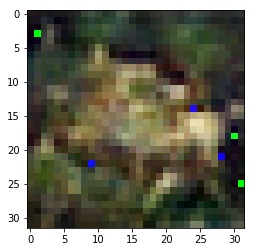

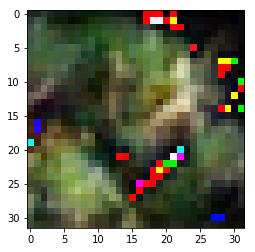

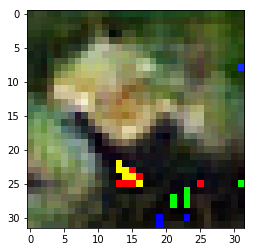

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Sample random points in the latent space
random_latent_vectors = np.random.normal(size=(10, latent_dim))

# Decode them to fake images
generated_images = generator.predict(random_latent_vectors)

for i in range(generated_images.shape[0]):
    img = image.array_to_img(generated_images[i] * 255., scale=False)
    plt.figure()
    plt.imshow(img)
    
plt.show()